**UTILITIES TO PARSE ILRS DATA AND COMPARE IT WITH TLE**

**PARSING CPF INTO PANDAS DATAFRAME TO EVALUATE TIME AND CARTESIAN COORDS**

In [ ]:
from IPython.display import clear_output
!pip install jdcal
!pip install sgp4
!pip install julian
!pip install skyfield
!pip install TLE-tools
!pip install spacetrack
clear_output()

In [1]:
#from SLRdata import parse_CPF
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import requests
import json
from scipy.interpolate import BarycentricInterpolator
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from jdcal import gcal2jd as date_to_JD
from jdcal import jd2gcal as JD_to_date
from sys import argv
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib
from tletools import TLE
from datetime import datetime
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from spacetrack import SpaceTrackClient
import spacetrack.operators as op
import warnings
from sgp4.api import days2mdhms,jday,Satrec,SatrecArray
from sgp4.api import WGS72OLD, WGS72, WGS84
from sgp4 import exporter
from sgp4.conveniences import sat_epoch_datetime
from astropy.time import Time
import julian
#import datetime
from tqdm import tqdm
import skyfield.sgp4lib as sgp4lib
from skyfield.data import iers
from skyfield.api import load
from skyfield import framelib
from skyfield.framelib import itrs
from skyfield.framelib import true_equator_and_equinox_of_date as of_date
from skyfield.api import EarthSatellite
from astropy import coordinates as coord, units as u
from astropy.coordinates import SkyCoord
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import glob
import os

In [3]:
names = ['index', 'name', 'norad', 'classification', 'int_desig', 'epoch_year',
        'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'set_num', 'inc', 'raan',
        'ecc', 'argp', 'M', 'n', 'rev_num']
ts = load.timescale()
def astropy_to_skyfield_time(iso_time):
    t_iso = ts.from_astropy(iso_time)
    return t_iso
def epoch_to_data(epoch_year,epoch_day):
    month, day, hour, minute, second = days2mdhms(int(epoch_year), float(epoch_day))
    return int(epoch_year), month, day, hour, minute, second
def date_to_jd(year,month, day, hour, minute, second):
    ts = load.timescale()
    time_jd = (ts.utc(year, month, day, hour, minute, second)).to_astropy()
    return time_jd#.to_value('jd'))
def jd_to_mjd(jd_t):
    try: mjd_t = jd_t.to_value('mjd')
    except: mjd_t = Time(Time((jd_t), format='jd')).to_value('mjd')
    return mjd_t
def mjd_to_jd(mjd_t):
    try: jd_t = mjd_t.to_value('jd')
    except: jd_t = Time(Time((mjd_t), format='mjd')).to_value('jd')
    return jd_t
def iso_to_jd(t_utc):
    try:jd_t = (t_utc).to_value('jd')
    except:jd_t =Time(Time((t_utc), format='iso')).to_value('jd')
    return jd_t
def jd_to_iso(jd_time):
    try:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    except:tm = Time(Time((jd_time), format='jd').to_value('iso'))
    return tm
def mjd_to_iso(mjd_time):
    tm = Time(Time((mjd_time), format='mjd').to_value('iso'))
    return tm
def tle_epoch_to_mjd(epoch_year,epoch_day):
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    jd_date = date_to_jd(year,month, day, hour, minute, second)#.to_astropy()
    mjd_date = jd_to_mjd(jd_date)
    return mjd_date
def timestamp_from_datetime(t):
    delta, JD = date_to_JD(t.year, t.month, t.day)
    seconds = t.microsecond / 1e6 + t.second + 60*t.minute + 3600*t.hour
    return int(JD) + seconds / 86400
def parse_CPF(raw_data):
    data = {}
    data["name"] = None
    data["start"] = None
    data["end"] = None
    data["predictions"] = []
    for line in raw_data.split("\n"):
        if line.startswith("H1") or line.startswith("h1"):
            data["name"] = line[35:45]
        elif line.startswith("H2") or line.startswith("h2"):
            data["start"] = datetime(
                year = int(line[26:30]),
                month = int(line[31:33]),
                day = int(line[34:36]),
                hour = int(line[37:39]),
                minute = int(line[40:42]),
                second = int(line[43:45])
            )
            data["end"] = datetime(
                year = int(line[46:50]),
                month = int(line[51:53]),
                day = int(line[54:56]),
                hour = int(line[57:59]),
                minute = int(line[60:62]),
                second = int(line[63:65])
            )
        elif line.startswith("10"):
            sline = [float(x) for x in line.split()]
            t = sline[2] + sline[3] / 86400
            data["predictions"].append((t, sline[5:8]))
    data_df = pd.DataFrame(data)
    #print(data_df.head())
    predictions = np.array(data_df["predictions"].values)
    mjds = np.array([predictions[i][0] for i in range(len(predictions))])
    coords = np.array([predictions[i][1] for i in range(len(predictions))])
    data_df['x_itrf'],data_df['y_itrf'],data_df['z_itrf'] =coords.T/1000# from m to km
    data_df['mjd'] = mjds
    jds = [mjd_to_jd(mjds[i]) for i in range(len(mjds))]
    data_df['jd'] = jds
    r_itrf = coords/1000
    #print(r_itrf.shape, r_itrf[0])
    iso_time = [jd_to_iso(jds[i]) for i in range(len(data_df))]
    #print(iso_time[0])
    rot_mats = [ITRS_to_J2000_matrix(iso_time[i]) for i in range(len(data_df))]
    r_j000 = np.array([np.dot(rot_mats[i],r_itrf[i]) for i in range(len(data_df))])
    #r_j000 = np.array([ITRS_to_J2000(r_itrf[i],np.zeros(3),jds[i])[0] for i in range(len(r_itrf))])
    #print(r_j000.shape,r_j000[0])
    data_df['x_j2000'],data_df['y_j2000'],data_df['z_j2000'] =r_j000.T
    df_reduced = data_df[['name','mjd','jd','x_itrf','y_itrf','z_itrf','x_j2000','y_j2000','z_j2000']]
    print(data["start"],data["end"])
    return df_reduced,data
def TEME_to_ITRS(r,v,jd_time):
    r_itrf,v_itrf= sgp4lib.TEME_to_ITRF(jd_time.to_value('jd'),np.asarray(r),np.asarray(v)*86400)
    v_itrf=v_itrf/86400
    return r_itrf,v_itrf
def ITRS_to_J2000_matrix(iso_time):
    gcrs2itrs_mat = framelib.itrs.rotation_at(astropy_to_skyfield_time(iso_time))
    itrs2gcrs_mat = inv(gcrs2itrs_mat)
    return itrs2gcrs_mat
def ITRS_to_J2000(r_itrf,v_itrf,jd_time):
    # Conversion from ITRS to J2000
    itrs = coord.ITRS(r_itrf[0]*u.km, r_itrf[1]*u.km, r_itrf[2]*u.km, v_itrf[0]*u.km/u.s, v_itrf[1]*u.km/u.s, v_itrf[2]*u.km/u.s, obstime=jd_to_iso(jd_time))
    gcrs = itrs.transform_to(coord.GCRS(obstime=jd_to_iso(jd_time)))
    r_j200,v_j2000=gcrs.cartesian.xyz.value,gcrs.velocity.d_xyz.value
    return r_j200,v_j2000
def make_line1(tle_df_row):
    s = '1 '+str(tle_df_row[2])+str(tle_df_row[3])
    for i in range(7):
        s=s+' '+str(tle_df_row[i+4])
    return s
def make_line2(tle_df_row):
    t= '2 '+str(tle_df_row[2])
    for i in range(6):
        t=t+' '+str(tle_df_row[i+11])
    return t
def tle_to_coords(sat_name,tle_df_row1,tle_df_row2,columns = names):
    splited_line1 = tle_df_row1.split()
    splited_line2 = tle_df_row2.split()
    epoch_year,epoch_day = splited_line1[3][:2], splited_line1[3][2:]
    year,month, day, hour, minute, second = epoch_to_data(epoch_year,epoch_day)
    year = int('20'+str(year))
    date_utc = [year,month, day, hour, minute, second]
    #print(year,month, day, hour, minute, second)
    jd, fr = jday(year,month, day, hour, minute, second)
    jd_time = jd+fr
    iso_time = jd_to_iso(jd_time)
    s = tle_df_row1[:-1]
    t = tle_df_row2[:-1]
    satellite = Satrec.twoline2rv(s, t,WGS84)#EarthSatellite(line1, line2, sat_name, ts)
    e, r_teme, v_teme = satellite.sgp4(jd, fr)
    #skyfield realization of getting position from tle data
    ts = load.timescale()
    tt = ts.utc(year,month, day, hour, minute, second)
    #EarthSatellite.from_satrec(satrec, ts)
    #satrec = Satrec()
    sat = EarthSatellite(s, t, sat_name[:-1], ts)
    geocentric = sat.at(tt)
    geocentric_coords = geocentric.position.km#.apparent()
    return np.array(e), np.array(r_teme), np.array(v_teme),iso_time,geocentric_coords


**FUNCTION FOR PARSING SPACETRACK.ORG ANG SAVE TLE DATA FROM THIS SOURCE**

In [4]:
def get_tle_from_spacetrack(id_sat,start,end,sat_name, dir):
    login = 'msubelyakovnv@yandex.ru'
    pswd = 'Workout2018!_2022'

    st = SpaceTrackClient(login, pswd)
    decay_epoch = op.inclusive_range(start, end)
    tle_data = st.tle(norad_cat_id=[id_sat], format='tle', epoch=decay_epoch)
    sat_name_for_csv = sat_name+'\n'
    with open(dir, "w") as text_file:#earth_sats_names_from_celestrak
        text_file.write(tle_data)
    ##########################################################################################
    with open(dir) as f:
        lines = f.readlines()
    #print(lines)
    for i in range(0,int(len(lines)*3/2)-1,3):
        lines.insert(i, sat_name_for_csv)
        d= {'name':0,
    'norad':0, 'classification':0, 'int_desig':0, 'epoch_year':0, 'epoch_day':0, 'dn_o2':0, 'ddn_o6':0, 'bstar':0, 'set_num':0, 'inc':0, 'raan':0, 'ecc':0, 'argp':0,
        'M':0, 'n':0, 'rev_num':0}
    t = pd.DataFrame(d, index=[0])
    tle_string = lines[0:3]
    #print(tle_string)
    tle_string = tle_string[0]+tle_string[1]+tle_string[2]
    tle_lines = tle_string.strip().splitlines()
    tle = TLE.from_lines(*tle_lines)
    for i in range(0,len(lines),3):
        tle_string = lines[i:i+3]
        tle_string = tle_string[0]+tle_string[1]+tle_string[2]
        tle_lines = tle_string.strip().splitlines()
        tle = TLE.from_lines(*tle_lines)
        d= {'name':tle.name,
        'norad':tle.norad, 'classification':tle.classification, 'int_desig':tle.int_desig,
            'epoch_year':tle.epoch_year, 'epoch_day':tle.epoch_day, 'dn_o2':tle.dn_o2, 'ddn_o6':tle.ddn_o6,
            'bstar':tle.bstar, 'set_num':tle.set_num, 'inc':tle.inc, 'raan':tle.raan, 'ecc':tle.ecc, 'argp':tle.argp,
        'M':tle.M, 'n':tle.n, 'rev_num':tle.rev_num}
        cols = d.keys()
        vals = d.values()
        t = t.append(dict(zip(cols, vals)), ignore_index=True)
    tle_df= t.iloc[1::].reset_index()
    tle_df.to_csv(dir.replace('txt','csv'))
    return lines,tle_df
def df_j2000_from_TLE(tle_strings, satname, sat_id):
    e, r_teme, v_teme,iso_time,geocentric_coords = tle_to_coords(tle_strings[0],tle_strings[1],tle_strings[2])
    d = {'name' :satname,'norad_id':sat_id,'mjd_t':jd_to_mjd(iso_to_jd(iso_time)),'jd_t':iso_to_jd(iso_time),
         'x_j2000_tle':geocentric_coords[0],
         'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
    cols = d.keys()
    vals = d.values()
    j2000_coords_from_TLE = pd.DataFrame(dict(zip(cols, vals)),index =[0])
    for i in tqdm(range(3,len(tle_strings),3)):
        sat_name,tle_df_row1,tle_df_row2 = tle_strings[i],tle_strings[1+i],tle_strings[2+i]
        e, r_teme, v_teme,iso_time, geocentric_coords = tle_to_coords(sat_name,tle_df_row1,tle_df_row2)
        x_j2000,y_j2000,z_j2000 = geocentric_coords
        d ={'name' :satname,'norad_id':sat_id,'mjd_t':jd_to_mjd(iso_to_jd(iso_time)),'jd_t':iso_to_jd(iso_time),
            'x_j2000_tle':geocentric_coords[0],
         'y_j2000_tle':geocentric_coords[1],'z_j2000_tle':geocentric_coords[2]}
        cols = d.keys()
        vals = d.values()
        j2000_coords_from_TLE = j2000_coords_from_TLE.append(dict(zip(cols, vals)), ignore_index=True)
    return j2000_coords_from_TLE

In [5]:
id_sat_tandemx,start,end,sat_name_tandemx = 41105,'2022-10-15','2022-10-16','tandemx'
id_sat_terrasarx,sat_name_terrasarx = 31698,'terrasarx'
id_sat_technosat,sat_name_technosat = 42829,'technosat'
ids_sat = [id_sat_tandemx,id_sat_technosat,id_sat_terrasarx]
j2000_coords_from_TLEs = []
sat_names = ['tandemx','technosat','terrasarx']
for i in range(1):
    dir_tle = '/content/drive/MyDrive/'+sat_names[i]+'_df_TLE_2021_2022.txt'
    tle_strings,tle_df = get_tle_from_spacetrack(ids_sat[i],start,end,sat_names[i],dir_tle)
    j2000_coords_from_TLE = df_j2000_from_TLE(tle_strings,sat_names[i], ids_sat[i])
    j2000_coords_from_TLEs.append(j2000_coords_from_TLE)
tle_strings

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/tandemx_df_TLE_2021_2022.txt'

In [ ]:
j2000_coords_from_TLEss = pd.concat([j2000_coords_from_TLEs[0], j2000_coords_from_TLEs[1],j2000_coords_from_TLEs[2]], ignore_index=True)
j2000_coords_from_TLEss.to_csv('/content/drive/MyDrive/3_LEO_df_TLE_2021_2022.csv')

In [ ]:
(j2000_coords_from_TLEs[0])

,name,norad_id,mjd_t,jd_t,x_j2000_tle,y_j2000_tle,z_j2000_tle
0,tandemx,36605,59215.098638,2.459216e+06,1105.202986,-687.155198,6753.596785
1,tandemx,36605,59215.433075,2.459216e+06,-2136.180449,-1285.993853,6410.938541
2,tandemx,36605,59215.433075,2.459216e+06,-2136.180449,-1285.993853,6410.938541
3,tandemx,36605,59215.827749,2.459216e+06,-1798.711547,-1247.031100,6520.829568
4,tandemx,36605,59215.827749,2.459216e+06,-1798.711547,-1247.031100,6520.829568
...,...,...,...,...,...,...,...
1645,tandemx,36605,59944.838266,2.459945e+06,6778.307980,1234.263479,-15.038256
1646,tandemx,36605,59945.826286,2.459946e+06,6756.337657,1349.326474,-14.997732
1647,tandemx,36605,59945.826286,2.459946e+06,6756.337657,1349.326474,-14.997732
1648,tandemx,36605,59946.814305,2.459947e+06,6732.414349,1463.936395,-14.943737


**NOW WE NEED TO MATCH TLE WITH ILRS ACCORDING MJD TIME IN ONE DF FOR CREATING DATASET FOR TRAINING**

**WE HAVE TO GET RID OF SIMILAR TIMESATMPS IN ILRS TO GET STRICTLY ASCENDING SEQUENCY OF STATE VECTORS**

##################    The array is strictly ascending ######################
2289


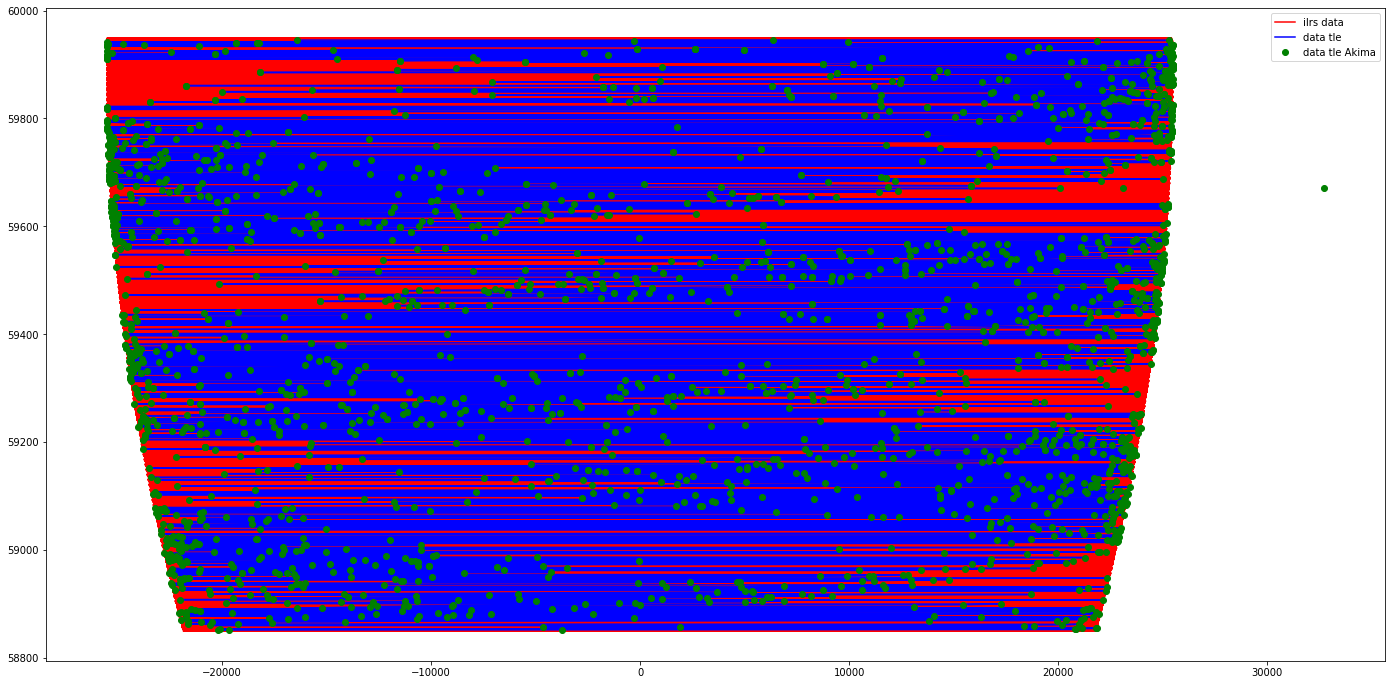

In [ ]:
tle_mjd, ilrs_mjd= j2000_coords_from_TLE['mjd_t'].values, ILRS_df['mjd'].values
unique_values, unique_indices = np.unique(ilrs_mjd, return_index=True)

# print the unique values and their indices
inique_idxs, unique_mjd_ilrs = [],[]
for i in range(len(unique_values)):
    inique_idxs.append(unique_indices[i])
    unique_mjd_ilrs.append(unique_values[i])
ilrs_mjd = ilrs_mjd[inique_idxs]
sorted_idxs = np.argsort(ilrs_mjd)
ilrs_mjd=ilrs_mjd[sorted_idxs]
x_tle = j2000_coords_from_TLE['x_j2000_tle']
x_ilrs, y_ilrs, z_ilrs = ILRS_df['x_j2000'].values[inique_idxs], ILRS_df['y_j2000'].values[inique_idxs], ILRS_df['z_j2000'].values[inique_idxs]
x_ilrs, y_ilrs, z_ilrs = x_ilrs[sorted_idxs], y_ilrs[sorted_idxs], z_ilrs[sorted_idxs]
# check if the array is strictly ascending
is_ascending = np.all(ilrs_mjd[1:] > ilrs_mjd[:-1])

if is_ascending:
    print("##################    The array is strictly ascending ######################")
else:
    print("###############  The array is not strictly ascending   ###########################")
x_akima = Akima1DInterpolator(ilrs_mjd, x_ilrs)(tle_mjd)
y_akima = Akima1DInterpolator(ilrs_mjd, y_ilrs)(tle_mjd)
z_akima = Akima1DInterpolator(ilrs_mjd, z_ilrs)(tle_mjd)
print(len(x_akima))
plt.figure(figsize=(24,12))
plt.plot(x_ilrs, ilrs_mjd, 'r-', label='ilrs data')
plt.plot(x_tle,tle_mjd,'b', label='data tle')
plt.plot(x_akima,tle_mjd,'go', label='data tle Akima')
plt.legend()
plt.show()

In [ ]:
# the 4 of 5 parts of CPF are similar according timestamps, have to drop them!
unique_values, unique_indices = np.unique(ilrs_mjd, return_index=True)

# print the unique values and their indices
inique_idxs, unique_mjd_ilrs = [],[]
for i in range(len(unique_values)):
    inique_idxs.append(unique_indices[i])
    unique_mjd_ilrs.append(unique_values[i])
    #print("Value: {}, Index: {}".format(unique_values[i], unique_indices[i]))
print(len(unique_mjd_ilrs),len(ilrs_mjd))

108289 108289


In [ ]:
def match_mjds_TLE_ILRS(ILRS_df,j2000_coords_from_TLE, filename='/content/drive/MyDrive/glonass105_TLE/matched_glonass105_TLE_ILRS_2020_2022.csv'):
    tle_mjd, ilrs_mjd= j2000_coords_from_TLE['mjd_t'].values, ILRS_df['mjd'].values
    unique_values, unique_indices = np.unique(ilrs_mjd, return_index=True)
    # find the unique values and their indices
    inique_idxs, unique_mjd_ilrs = [],[]
    for i in range(len(unique_values)):
        inique_idxs.append(unique_indices[i])
        unique_mjd_ilrs.append(unique_values[i])
    ilrs_mjd = ilrs_mjd[inique_idxs]
    sorted_idxs = np.argsort(ilrs_mjd)
    ilrs_mjd=ilrs_mjd[sorted_idxs]
    x_ilrs, y_ilrs, z_ilrs = ILRS_df['x_j2000'].values[inique_idxs], ILRS_df['y_j2000'].values[inique_idxs], ILRS_df['z_j2000'].values[inique_idxs]
    x_ilrs, y_ilrs, z_ilrs = x_ilrs[sorted_idxs], y_ilrs[sorted_idxs], z_ilrs[sorted_idxs]
    # check if the array is strictly ascending
    x_akima = Akima1DInterpolator(ilrs_mjd, x_ilrs)(tle_mjd)
    y_akima = Akima1DInterpolator(ilrs_mjd, y_ilrs)(tle_mjd)
    z_akima = Akima1DInterpolator(ilrs_mjd, z_ilrs)(tle_mjd)
    j2000_coords_from_TLE['x_j2000_ilrs_Akima'] = x_akima
    j2000_coords_from_TLE['y_j2000_ilrs_Akima'] = y_akima
    j2000_coords_from_TLE['z_j2000_ilrs_Akima'] = z_akima
    #j2000_coords_from_TLE['mjd_ILRS'] = ilrs_mjd[matching_idxs]
    j2000_coords_from_TLE.to_csv(filename)
    return j2000_coords_from_TLE
#ILRS_df=pd.read_csv('/content/drive/MyDrive/glonass105/full_glonass105_df_ILRS_2020.csv')
matched_TLE_ILRS_df = match_mjds_TLE_ILRS(ILRS_df,j2000_coords_from_TLE)
print(matched_TLE_ILRS_df.head(),matched_TLE_ILRS_df.tail())
# print(tle_df.head(),tle_df.tail())

          name  norad_id         mjd_t          jd_t   x_j2000_tle  \
0  glonass-105     32276  58850.673296  2.458851e+06 -19671.223947   
1  glonass-105     32276  58851.079421  2.458852e+06 -20224.774913   
2  glonass-105     32276  58851.473326  2.458852e+06  -3736.441929   
3  glonass-105     32276  58852.259349  2.458853e+06  20861.539807   
4  glonass-105     32276  58852.546680  2.458853e+06 -20132.743941   

    y_j2000_tle   z_j2000_tle  x_j2000_ilrs_Akima  y_j2000_ilrs_Akima  \
0 -15716.060131  -4202.738245       -19652.651394       -15699.975623   
1  -6079.330250  14348.625749       -20205.502182        -6073.945979   
2   9958.974424  23195.054623        -3736.502372         9945.746865   
3   7436.954501 -12606.489410        20853.124174         7434.244983   
4 -15390.581495  -3075.830883       -20111.205216       -15373.618901   

   z_j2000_ilrs_Akima  
0        -4197.229451  
1        14333.834852  
2        23170.214349  
3       -12600.282672  
4        -3072.48694

**NOW GO TO PYTORCH AND NN INITALIZATION**

In [6]:
import random
import torch
import torch.nn as nn
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [7]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 128)
        self.dp = nn.Dropout(0.15)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 3)
        self.activation = nn.ReLU()

    def forward(self, x): # Called inside __call__ method
        x = self.fc1(x)
        x = self.activation(x)
        x = self.bn1(x)#.unsqueeze(1))
        x = self.fc2(x)#.squeeze(1))
        x = self.activation(x)
        x = self.bn2(x)#.unsqueeze(1))
        x = self.fc3(x)#.squeeze(1))
        x = self.activation(x)
        x = self.bn3(x)#.unsqueeze(1))
        x = self.fc4(x)#.squeeze(1))
        return x

In [ ]:
model = FCNet()
optimizer = torch.optim.AdamW(model.parameters())
ex = torch.randn(10,12)
print(model(ex))#
criterion =  torch.nn.MSELoss()

tensor([[-5.4799e-01, -2.0025e-01,  1.4180e-01],
        [ 6.6033e-01,  1.9099e-01,  1.5803e-01],
        [-4.0962e-01,  4.9074e-01, -2.1974e-01],
        [ 2.2506e-02, -1.2135e+00,  6.1210e-01],
        [-4.3610e-02, -5.3179e-02,  3.6123e-01],
        [-4.0254e-02, -1.4263e-01, -8.2701e-02],
        [-6.6314e-01,  2.6279e-01,  3.9245e-01],
        [ 5.9475e-01, -2.9374e-02, -9.0357e-01],
        [-2.5621e-01, -8.2045e-04, -8.4546e-01],
        [-4.5947e-01, -5.3502e-01, -3.3887e-01]], grad_fn=<AddmmBackward0>)


In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, bs=100):
    train_losses,val_losses, tle_ilrs_losses = [],[],[]
    model.cuda()
    for epoch in range(num_epochs):
        if epoch%500 == 0:
        print('epoch =',epoch+1)
        total, ep_loss, val_loss, tle_ilrs_loss = 0, 0, 0, 0
        for tle, vec_state, xyz_sgp4  in train_loader:
            tle, vec_state, xyz_sgp4 = tle.cuda(), vec_state.cuda(), xyz_sgp4.cuda()
            optimizer.zero_grad()
            outputs = model(tle)
            loss = criterion(outputs, vec_state)
            loss.backward()
            optimizer.step()
            total += vec_state.size(0)
            ep_loss += loss.item()
        train_losses.append(ep_loss/bs)#.cpu().detach()
        with torch.no_grad():
            for tle, vec_state,xyz_sgp4 in val_loader:
                tle, vec_state, xyz_sgp4 = tle.cuda(), vec_state.cuda(), xyz_sgp4.cuda()
                outputs = model(tle)
                loss = criterion(outputs, vec_state)
                val_loss = loss.item() + val_loss
                tle_ilrs_loss = tle_ilrs_loss+ criterion(xyz_sgp4, vec_state).item()
            val_losses.append(val_loss/bs)#cpu().detach().numpy()
            tle_ilrs_losses.append(tle_ilrs_loss/bs)
    model_name = '/content/drive/MyDrive/fc_models/model_'+str(epoch)
    torch.save(model.state_dict(),model_name)
    print('##############model saved after training! ###############')
    return train_losses,val_losses,tle_ilrs_losses

**SEVERAL VALUES OF ILRS COPORDS WERE INTERPOLATED TOO BADLY! NEED TO IDENTIFY AND DROP THEM ALL FROM DATASET!!!**

In [ ]:
df_dir = '/content/drive/MyDrive/glonass105_TLE/matched_glonass105_TLE_ILRS_2020_2022.csv'
df_TLE_dir= '/content/drive/MyDrive/glonass105_TLE/full_glonass105_df_TLE_2020_2022.csv'
df_tle_ilrs = pd.read_csv(df_dir)
df_TLE = pd.read_csv(df_TLE_dir)
needed_columns = ['epoch_year', 'epoch_day', 'dn_o2', 'ddn_o6', 'bstar', 'inc',
        'raan', 'ecc', 'argp', 'M', 'n', 'rev_num']
dataset_df = df_TLE[needed_columns]
ilrs_coords = df_tle_ilrs[['x_j2000_ilrs_Akima','y_j2000_ilrs_Akima','z_j2000_ilrs_Akima']]
sgp4_coords = df_tle_ilrs[['x_j2000_tle','y_j2000_tle','z_j2000_tle']]
delta_x = sgp4_coords['x_j2000_tle'].values - ilrs_coords['x_j2000_ilrs_Akima'].values
delta_y = sgp4_coords['y_j2000_tle'].values - ilrs_coords['y_j2000_ilrs_Akima'].values
delta_z = sgp4_coords['z_j2000_tle'].values - ilrs_coords['z_j2000_ilrs_Akima'].values

####### REMOVE BAD INTERPOLATIONS
delta_coords = sgp4_coords.values-ilrs_coords.values
#append deltas to ilrs df
ilrs_coords['delta_x'] = delta_x
ilrs_coords['delta_y'] = delta_y
ilrs_coords['delta_z'] = delta_z
bad_interpolations = []
for i in range(len(delta_coords)):
  #print(np.linalg.norm(delta_coords[i]))
  if np.linalg.norm(delta_coords[i])>10:
    bad_interpolations.append(i)
print('bad_interpolations indices',len(bad_interpolations),bad_interpolations)
##### DROP THIS ODD VALUES FROM DF
dataset_df = dataset_df.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
ilrs_coords = ilrs_coords.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
sgp4_coords = sgp4_coords.drop(index = bad_interpolations).reset_index().drop(columns = ['index'])
print(dataset_df.head(), ilrs_coords.head())
#sgp4_coords = torch.tensor(np.array([sgp4_coords.iloc[i].values for i in range(len(sgp4_coords))]),dtype=torch.float32)
dataset = []
for i in range(len(dataset_df)):
  tle_seq = torch.tensor(dataset_df.iloc[i].values, dtype=torch.float32)
  xyz_ilrs = torch.tensor(ilrs_coords.iloc[i].values, dtype=torch.float32)
  xyz_sgp4 = torch.tensor(sgp4_coords.iloc[i].values, dtype=torch.float32)
  sample = (tle_seq, xyz_sgp4, xyz_ilrs)
  dataset.append(sample)
tle_0, xyz_0_sgp4, xyz_ilrs = dataset[0]
print('dataset sample:',tle_0, xyz_0_sgp4, xyz_ilrs)
#df_tle_ilrs.head(),df_TLE.head(),dataset[0]

bad_interpolations indices 51 [0, 1, 2, 3, 4, 5, 53, 54, 55, 56, 57, 58, 59, 61, 62, 76, 77, 78, 79, 80, 81, 82, 83, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 365, 367, 368, 369, 398, 400, 401, 403, 404, 405, 406, 407, 1723, 1724, 1725, 1726, 2121, 2122]
   epoch_year  epoch_day         dn_o2  ddn_o6   bstar      inc     raan  \
0        2020   6.160877 -2.200000e-07     0.0  0.0001  65.9401  34.4494   
1        2020   6.622151 -1.900000e-07     0.0  0.0001  65.9404  34.4343   
2        2020   7.585895 -1.500000e-07     0.0  0.0001  65.9409  34.4022   
3        2020   8.638364 -1.200000e-07     0.0  0.0001  65.9413  34.3671   
4        2020   9.554474 -1.100000e-07     0.0  0.0001  65.9415  34.3368   

        ecc      argp         M         n  rev_num  
0  0.001117  317.8469   28.2875  2.131036     9492  
1  0.001125  317.9151   22.0941  2.131036     9493  
2  0.001128  317.8695   41.4924  2.131036     9495  
3  0.001130  317.8168  128.9637  2.131036     9498  
4  0.001134  31

In [ ]:
trainset, valset, testset  = random_split(dataset, [0.75, 0.15, 0.1])
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size+3, shuffle=False)
print(trainset[0])

(tensor([ 2.0200e+03,  3.2284e+02, -7.1000e-07,  0.0000e+00,  0.0000e+00,
         6.6034e+01,  2.3913e+01,  9.0700e-04,  3.1764e+02,  3.3311e+02,
         2.1310e+00,  1.0167e+04]), tensor([ 12083.8740,  -5261.5317, -21822.5469]), tensor([ 1.2080e+04, -5.2639e+03, -2.1822e+04,  3.8836e+00,  2.4144e+00,
        -9.6215e-02]))


epoch = 1
epoch = 501
epoch = 1001
epoch = 1501
epoch = 2001
epoch = 2501
epoch = 3001
epoch = 3501
epoch = 4001
epoch = 4501
epoch = 5001
epoch = 5501
epoch = 6001
epoch = 6501
epoch = 7001
epoch = 7501
epoch = 8001
epoch = 8501
epoch = 9001
epoch = 9501
##############model saved after training! ###############


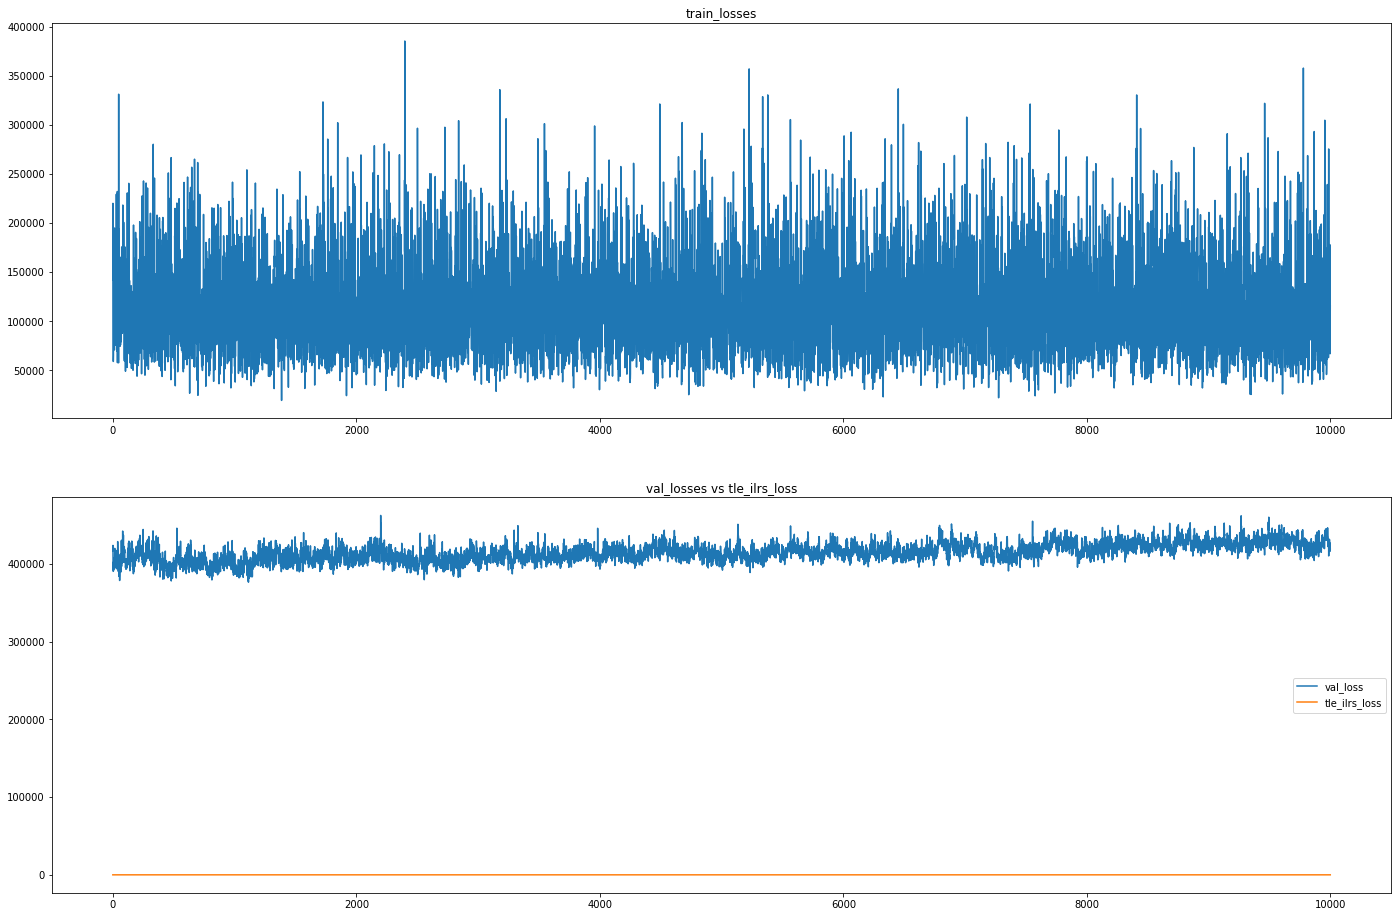

In [ ]:
model.train()
num_epochs = 10000
train_losses,val_losses, tle_ilrs_losses = train(model,train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, bs = batch_size)
fig, ax = plt.subplots(2,1, figsize = (24,16))
ax[0].plot(np.arange(num_epochs),train_losses, label = 'train_loss')
ax[1].plot(np.arange(num_epochs),val_losses, label = 'val_loss')
ax[1].plot(np.arange(num_epochs),tle_ilrs_losses, label = 'tle_ilrs_loss')
ax[0].set_title('train_losses')
ax[1].set_title('val_losses vs tle_ilrs_loss')
plt.legend()
plt.show()

**TESTING ON TEST_DATASET**

In [ ]:
model.eval().cuda()
for tle, vec_state, xyz_sgp4  in test_loader:
  tle, vec_state, xyz_sgp4 = tle.cuda(), vec_state.cuda(), xyz_sgp4.cuda()
  optimizer.zero_grad()
  outputs = model(tle)
  print('outputs =',outputs, 'ilrs state vec =',vec_state,'rmse = ',criterion(outputs, vec_state).item()/(batch_size+3))

**LETS TRY ANOTHER APPROACH AND CONVERT SGP4 STATE_VEC TO ILRS STATE VEC**

In [ ]:
#normalization
def normalize(data, mean, std):
  eps = 1e-8
  return (data - mean) / (std+eps)
def unnormalize(data, mean, std):
  return data * std + mean
print(ilrs_coords.head())

   x_j2000_ilrs_Akima  y_j2000_ilrs_Akima  z_j2000_ilrs_Akima   delta_x  \
0        21851.494877        11849.020362        -5615.669716  1.167873   
1        21790.177778        10513.965494        -8001.554493  0.959461   
2        21149.884478        14217.351944         -289.872462  2.153208   
3        -4628.277816         9389.517626        23274.468488  6.267312   
4         1908.445371        13048.299185        21840.287990  6.817662   

    delta_y   delta_z  
0 -1.344165 -3.954652  
1  0.327136 -0.890922  
2 -1.331877 -2.276653  
3  3.243213 -1.388498  
4  2.887789 -2.936332  


In [ ]:
#merge xyz_sgp4_to TLE df for new model training
modified_dataset = np.array([(torch.cat([dataset[i][0],dataset[i][1]], dim =0), dataset[i][-1]) for i in range(len(dataset))])
X = np.array([np.array(torch.cat([dataset[i][0],dataset[i][1]], dim =0)) for i in range(len(dataset))])
Y = np.array([np.array(dataset[i][-1]) for i in range(len(dataset))])
mean_x, mean_y = np.mean(X, axis=0), np.mean(Y, axis=0)
std_x, std_y = np.std(X, axis=0), np.std(Y, axis=0)
print('mean are:',mean_x, mean_y)
print('std are:',std_x, std_y)
X_norm, Y_norm = normalize(X,mean_x, std_x), normalize(Y,mean_y, std_y)
modified_dataset_norm = np.array([np.array([X_norm[i], Y_norm[i]]) for i in range(len(dataset))])

mean are: [ 2.0210496e+03  1.8729007e+02 -5.8448717e-07  0.0000000e+00
  2.3905421e-05  6.6058983e+01  3.3043598e+01  1.0103233e-03
  3.2742889e+02  1.7203363e+02  2.1310296e+00  1.0696416e+04
  8.6822632e+02 -2.2714659e+02 -2.4946027e+02] [ 8.6800989e+02 -2.2731122e+02 -2.4957674e+02  2.1571243e-01
  1.6442400e-01  1.1603964e-01]
std are: [7.9527903e-01 1.0740616e+02 1.8034793e-07 0.0000000e+00 4.2650270e-05
 4.2868149e-02 7.4013176e+01 1.6495926e-04 9.6445818e+00 1.0681384e+02
 5.7362417e-06 6.4492865e+02 1.8472531e+04 8.5588672e+03 1.5340189e+04] [1.8472650e+04 8.5590586e+03 1.5340269e+04 2.1859369e+00 1.4005479e+00
 2.3742263e+00]


In [ ]:
modified_dataset_norm_list = []
for i in range(len(modified_dataset_norm)):
  modified_dataset_norm[i][0] = torch.tensor(modified_dataset_norm[i][0],dtype = torch.float32)#.item()
  modified_dataset_norm[i][1] = torch.tensor(modified_dataset_norm[i][1],dtype = torch.float32)#.item()
  modified_dataset_norm_list.append((torch.tensor(modified_dataset_norm[i][0],dtype = torch.float32),torch.tensor(modified_dataset_norm[i][1],dtype = torch.float32)))
  #print(modified_dataset_norm[i][0].dtype,modified_dataset_norm[i][1].dtype)
trainset, valset, testset  = random_split(modified_dataset_norm_list, [0.75, 0.15, 0.1])
batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size+3, shuffle=False)
x,y = trainset[0]
x,y

(tensor([-1.3197, -0.5184, -1.0271,  0.0000,  1.7837, -1.7842, -0.0375,  0.9764,
          0.6424, -0.3748,  1.4107, -1.4520, -0.6396,  0.6330,  1.4806]),
 tensor([-0.6394,  0.6332,  1.4805, -1.1935, -1.0443,  0.4191]))

In [ ]:
testset[0]

(tensor([-0.0623,  0.4097, -0.4492,  0.0000, -0.5604,  0.5928, -0.2466, -1.3974,
          1.1015,  0.8835,  1.0373,  0.0862, -0.5004, -1.3515, -1.3539]),
 tensor([-0.5004, -1.3515, -1.3538,  0.0543, -0.2621, -0.5375]))

In [ ]:
class FC_SGP4_to_ILRS(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 128)
        self.dp = nn.Dropout(0.15)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64+128)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64+128, 64)
        self.fc5 = nn.Linear(64, 3)
        self.activation = nn.ReLU()

    def forward(self, x): # Called inside __call__ method
        x = self.fc1(x)
        x = self.activation(x)
        xx = self.bn1(x)
        x = self.fc2(xx)
        x = self.activation(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = torch.cat([x,xx], dim = -1)
        x = self.bn3(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.bn4(x)
        x = self.fc5(x)
        #x = self.activation(x)
        return x

In [ ]:
class FC_tiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)
        self.bn = nn.BatchNorm1d(12)
        self.fc4 = nn.Linear(4, 3)
        self.activation = nn.ReLU()

    def forward(self, x): # Called inside __call__ method
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        return x

In [ ]:
def train_sgp4_to_ilrs(model, train_loader, val_loader, criterion, optimizer, cur_ep=0, num_epochs=1000, bs=100):
    train_losses,val_losses, tle_ilrs_losses = [],[],[]
    model.cuda()
    for epoch in range(num_epochs):
      if epoch%500 == 0:
        print('epoch =',epoch+1)
      total, ep_loss, val_loss, tle_ilrs_loss = 0, 0, 0, 0
      for tle, vec_state  in train_loader:
          ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
          tle, ilrs, delta_r = tle.cuda(), ilrs.cuda(),delta_r.cuda()
          optimizer.zero_grad()
          outputs = model(tle)
          loss = criterion(outputs, delta_r)
          loss.backward()
          optimizer.step()
          total += vec_state.size(0)
          ep_loss += loss.item()
      train_losses.append(ep_loss/bs)#.cpu().detach()
      with torch.no_grad():
          for tle, vec_state in val_loader:
            ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
            tle, ilrs, delta_r = tle.cuda(), ilrs.cuda(),delta_r.cuda()
            outputs = model(tle)
            loss = criterion(outputs, delta_r)
            val_loss = loss.item() + val_loss
          val_losses.append(val_loss/bs)#cpu().detach().numpy()
    model_name = '/content/drive/MyDrive/fc_models/tiny_model_'+str(cur_ep+epoch+1)
    torch.save(model.state_dict(),model_name)
    print('##############model saved after training! ###############')
    return train_losses,val_losses#,tle_ilrs_losses

In [ ]:
######## INITIALIZE OUT TINY FC MODEL s############
model_sgp2ilrs = FC_tiny()

epoch = 1
epoch = 501
epoch = 1001
epoch = 1501
epoch = 2001
epoch = 2501
epoch = 3001
epoch = 3501
epoch = 4001
epoch = 4501
epoch = 5001
epoch = 5501
epoch = 6001
epoch = 6501
epoch = 7001
epoch = 7501
epoch = 8001
epoch = 8501
epoch = 9001
epoch = 9501
##############model saved after training! ###############


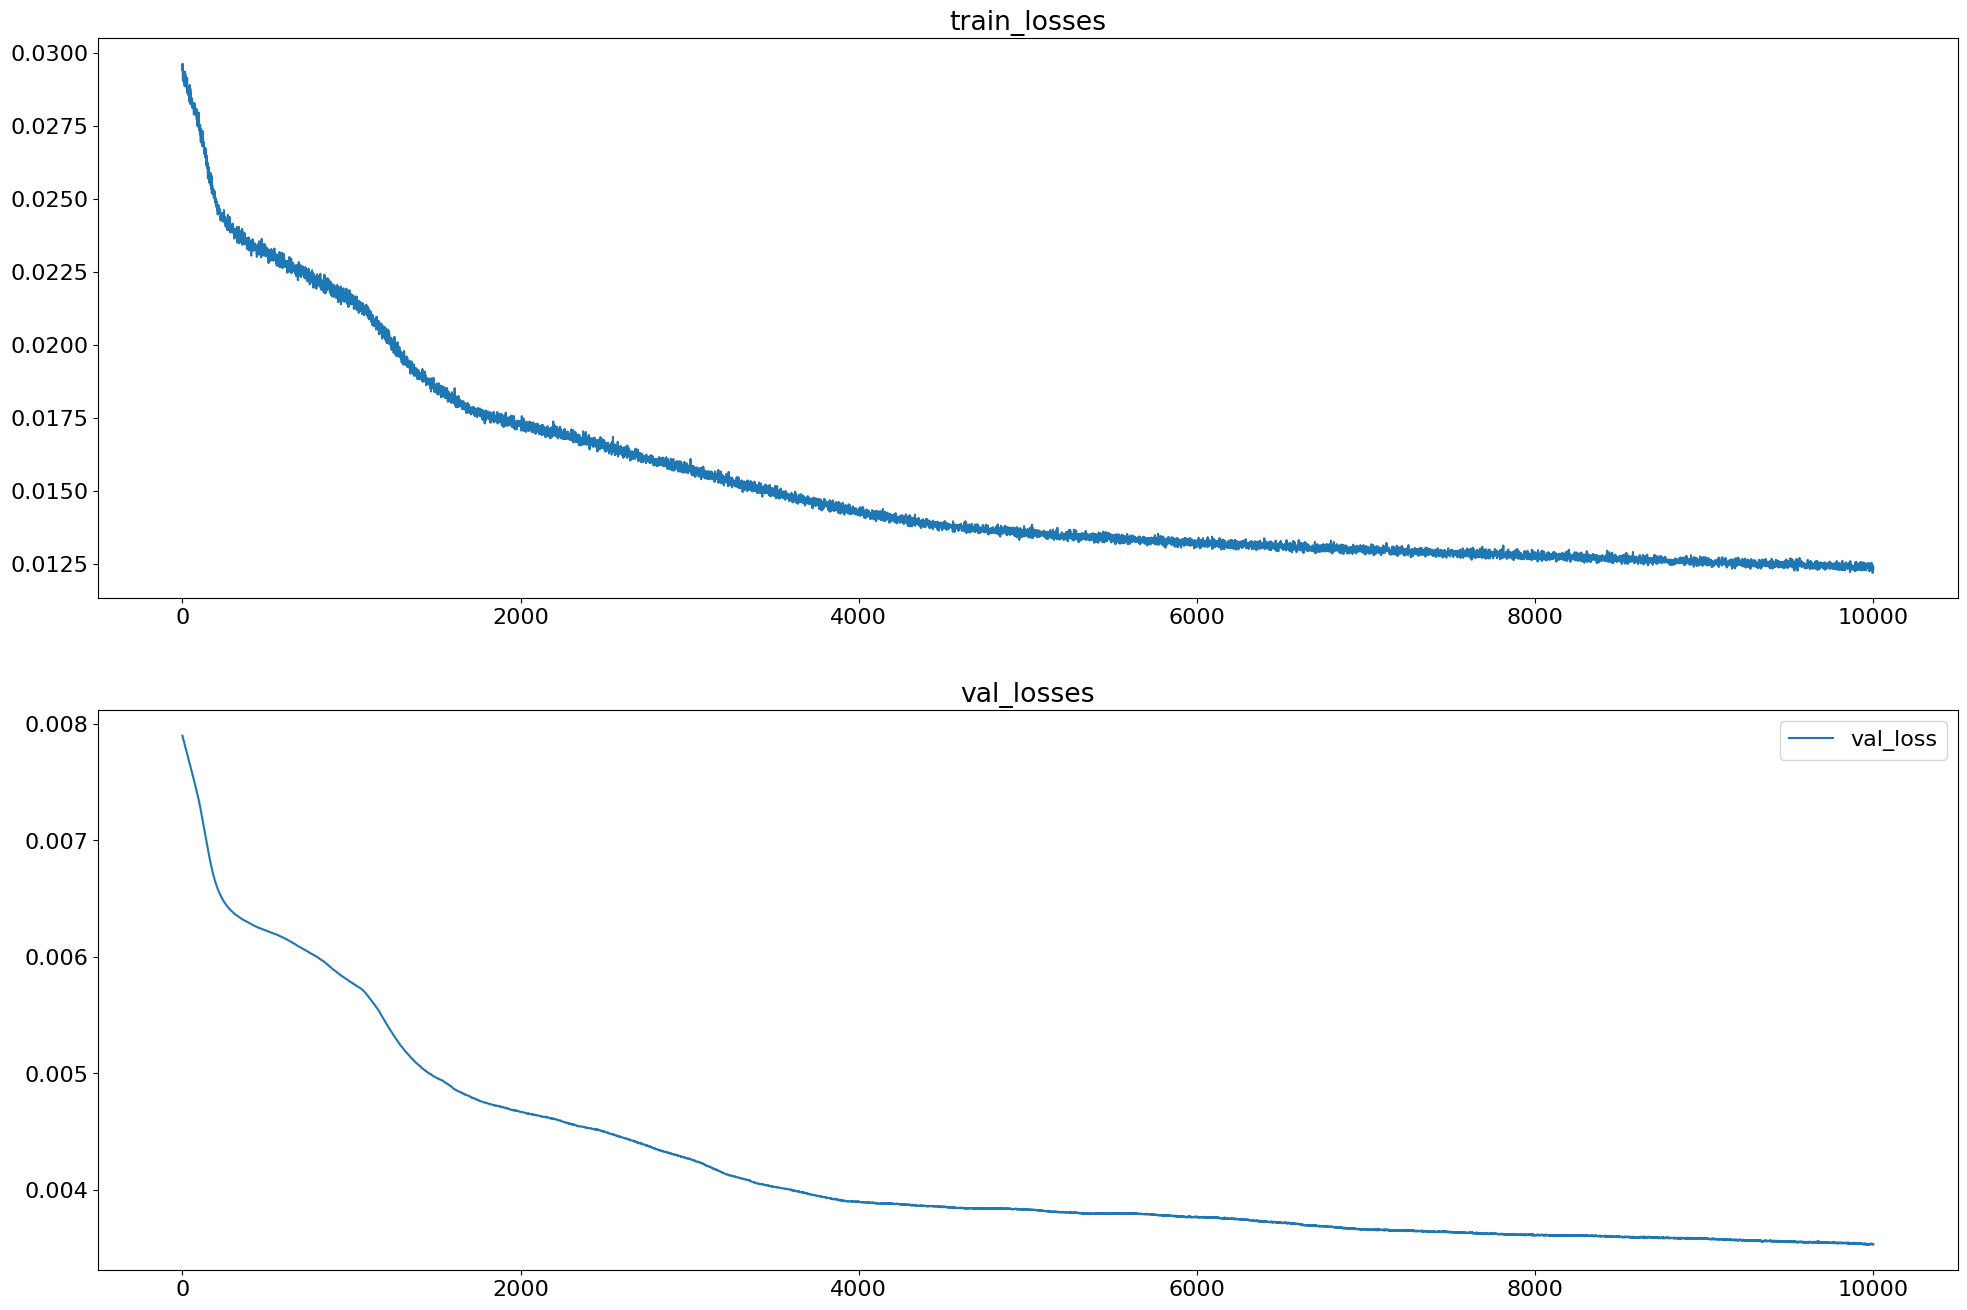

In [ ]:
#model_dir = '/content/drive/MyDrive/fc_models/model_10000'
#model_sgp2ilrs.load_state_dict(torch.load(model_dir))
lr = 1e-4
optimizer = torch.optim.AdamW(model_sgp2ilrs.parameters(), lr= lr)
num_epochs = 10000
cur_ep = 0#30000
model_sgp2ilrs.train()
train_losses,val_losses = train_sgp4_to_ilrs(model_sgp2ilrs,train_loader, val_loader, criterion, optimizer,cur_ep=cur_ep, num_epochs=num_epochs, bs = batch_size)
fig, ax = plt.subplots(2,1, figsize = (24,16))
ax[0].plot(np.arange(num_epochs),train_losses, label = 'train_loss')
ax[1].plot(np.arange(num_epochs),val_losses, label = 'val_loss')
ax[0].set_title('train_losses')
ax[1].set_title('val_losses')
plt.legend()
plt.show()


**TESTING SGP4 to ILRS STATE VEC CORRECTION ON TEST DATA**

In [ ]:
criterion =  torch.nn.MSELoss()
model_dir = '/content/drive/MyDrive/fc_models/tiny_model_40000'
model_sgp2ilrs.load_state_dict(torch.load(model_dir))
model_sgp2ilrs.eval().cuda()
mean_sgp4, std_sgp4 = mean_x[-3:], std_x[-3:]
mean_delta, std_delta = mean_y[-3:], std_y[-3:]

for tle, vec_state  in test_loader:
  ilrs, delta_r = vec_state[:,:3], vec_state[:,3:]
  tle = tle.cuda()
  sgp4_xyz = tle[:,-3:]
  sgp4_xyz = unnormalize(sgp4_xyz.cpu().detach().numpy(), mean_sgp4, std_sgp4)
  outputs = model_sgp2ilrs(tle).cpu().detach().numpy()
  outputs_inv = unnormalize(outputs, mean_delta, std_delta)
  ilrs_xyz_inv = unnormalize(vec_state.cpu().detach().numpy(), mean_y, std_y)
  deltas = ilrs_xyz_inv[:,-3:]

  print('rmse = ',np.sqrt(criterion(torch.tensor(deltas), torch.tensor(outputs_inv)).item()))
  print('real rmse = ',np.sqrt(criterion(torch.tensor(sgp4_xyz), torch.tensor(ilrs_xyz_inv[:,:3])).item()))
  #print('outputs =',outputs_inv, 'ilrs state vec =',ilrs_xyz_inv,'rmse = ',criterion(torch.tensor(outputs_inv), torch.tensor(ilrs_xyz_inv)).item()/(batch_size+3))

rmse =  1.3901702908963114
real rmse =  2.0502550013043583


In [ ]:
corrected_xyz = sgp4_xyz-outputs_inv
for idx in range(10,20):
  print('sample', idx+1, '################################')
  print('FC output xyz:',corrected_xyz[idx],'\nreal ILRS xyz:',ilrs_xyz_inv[idx,:3],'\nreal SGP4 xyz:',sgp4_xyz[idx])

sample 11 ################################
FC output xyz: [ 20781.91    2027.486 -14617.027] 
real ILRS xyz: [ 20782.213    2025.7407 -14616.003 ] 
real SGP4 xyz: [ 20783.84     2029.5878 -14615.424 ]
sample 12 ################################
FC output xyz: [   502.5979 -11631.324  -22688.967 ] 
real ILRS xyz: [   502.25372 -11629.848   -22690.432  ] 
real SGP4 xyz: [   502.7667 -11631.047  -22688.19  ]
sample 13 ################################
FC output xyz: [-10562.364 -10951.668 -20472.996] 
real ILRS xyz: [-10560.026 -10951.523 -20474.285] 
real SGP4 xyz: [-10561.795 -10951.374 -20472.113]
sample 14 ################################
FC output xyz: [ 16221.925   -7274.6514 -18273.207 ] 
real ILRS xyz: [ 16222.676   -7274.4663 -18274.498 ] 
real SGP4 xyz: [ 16220.707   -7275.7886 -18275.607 ]
sample 15 ################################
FC output xyz: [ 5663.699 10758.828 22423.65 ] 
real ILRS xyz: [ 5660.516 10759.187 22424.596] 
real SGP4 xyz: [ 5663.916 10759.926 22425.248]
sample 

**LETS VISUALIZE IT IN THE CRS, WHERE THE (0,0,0) is ILRS TRUE STATE VEC**

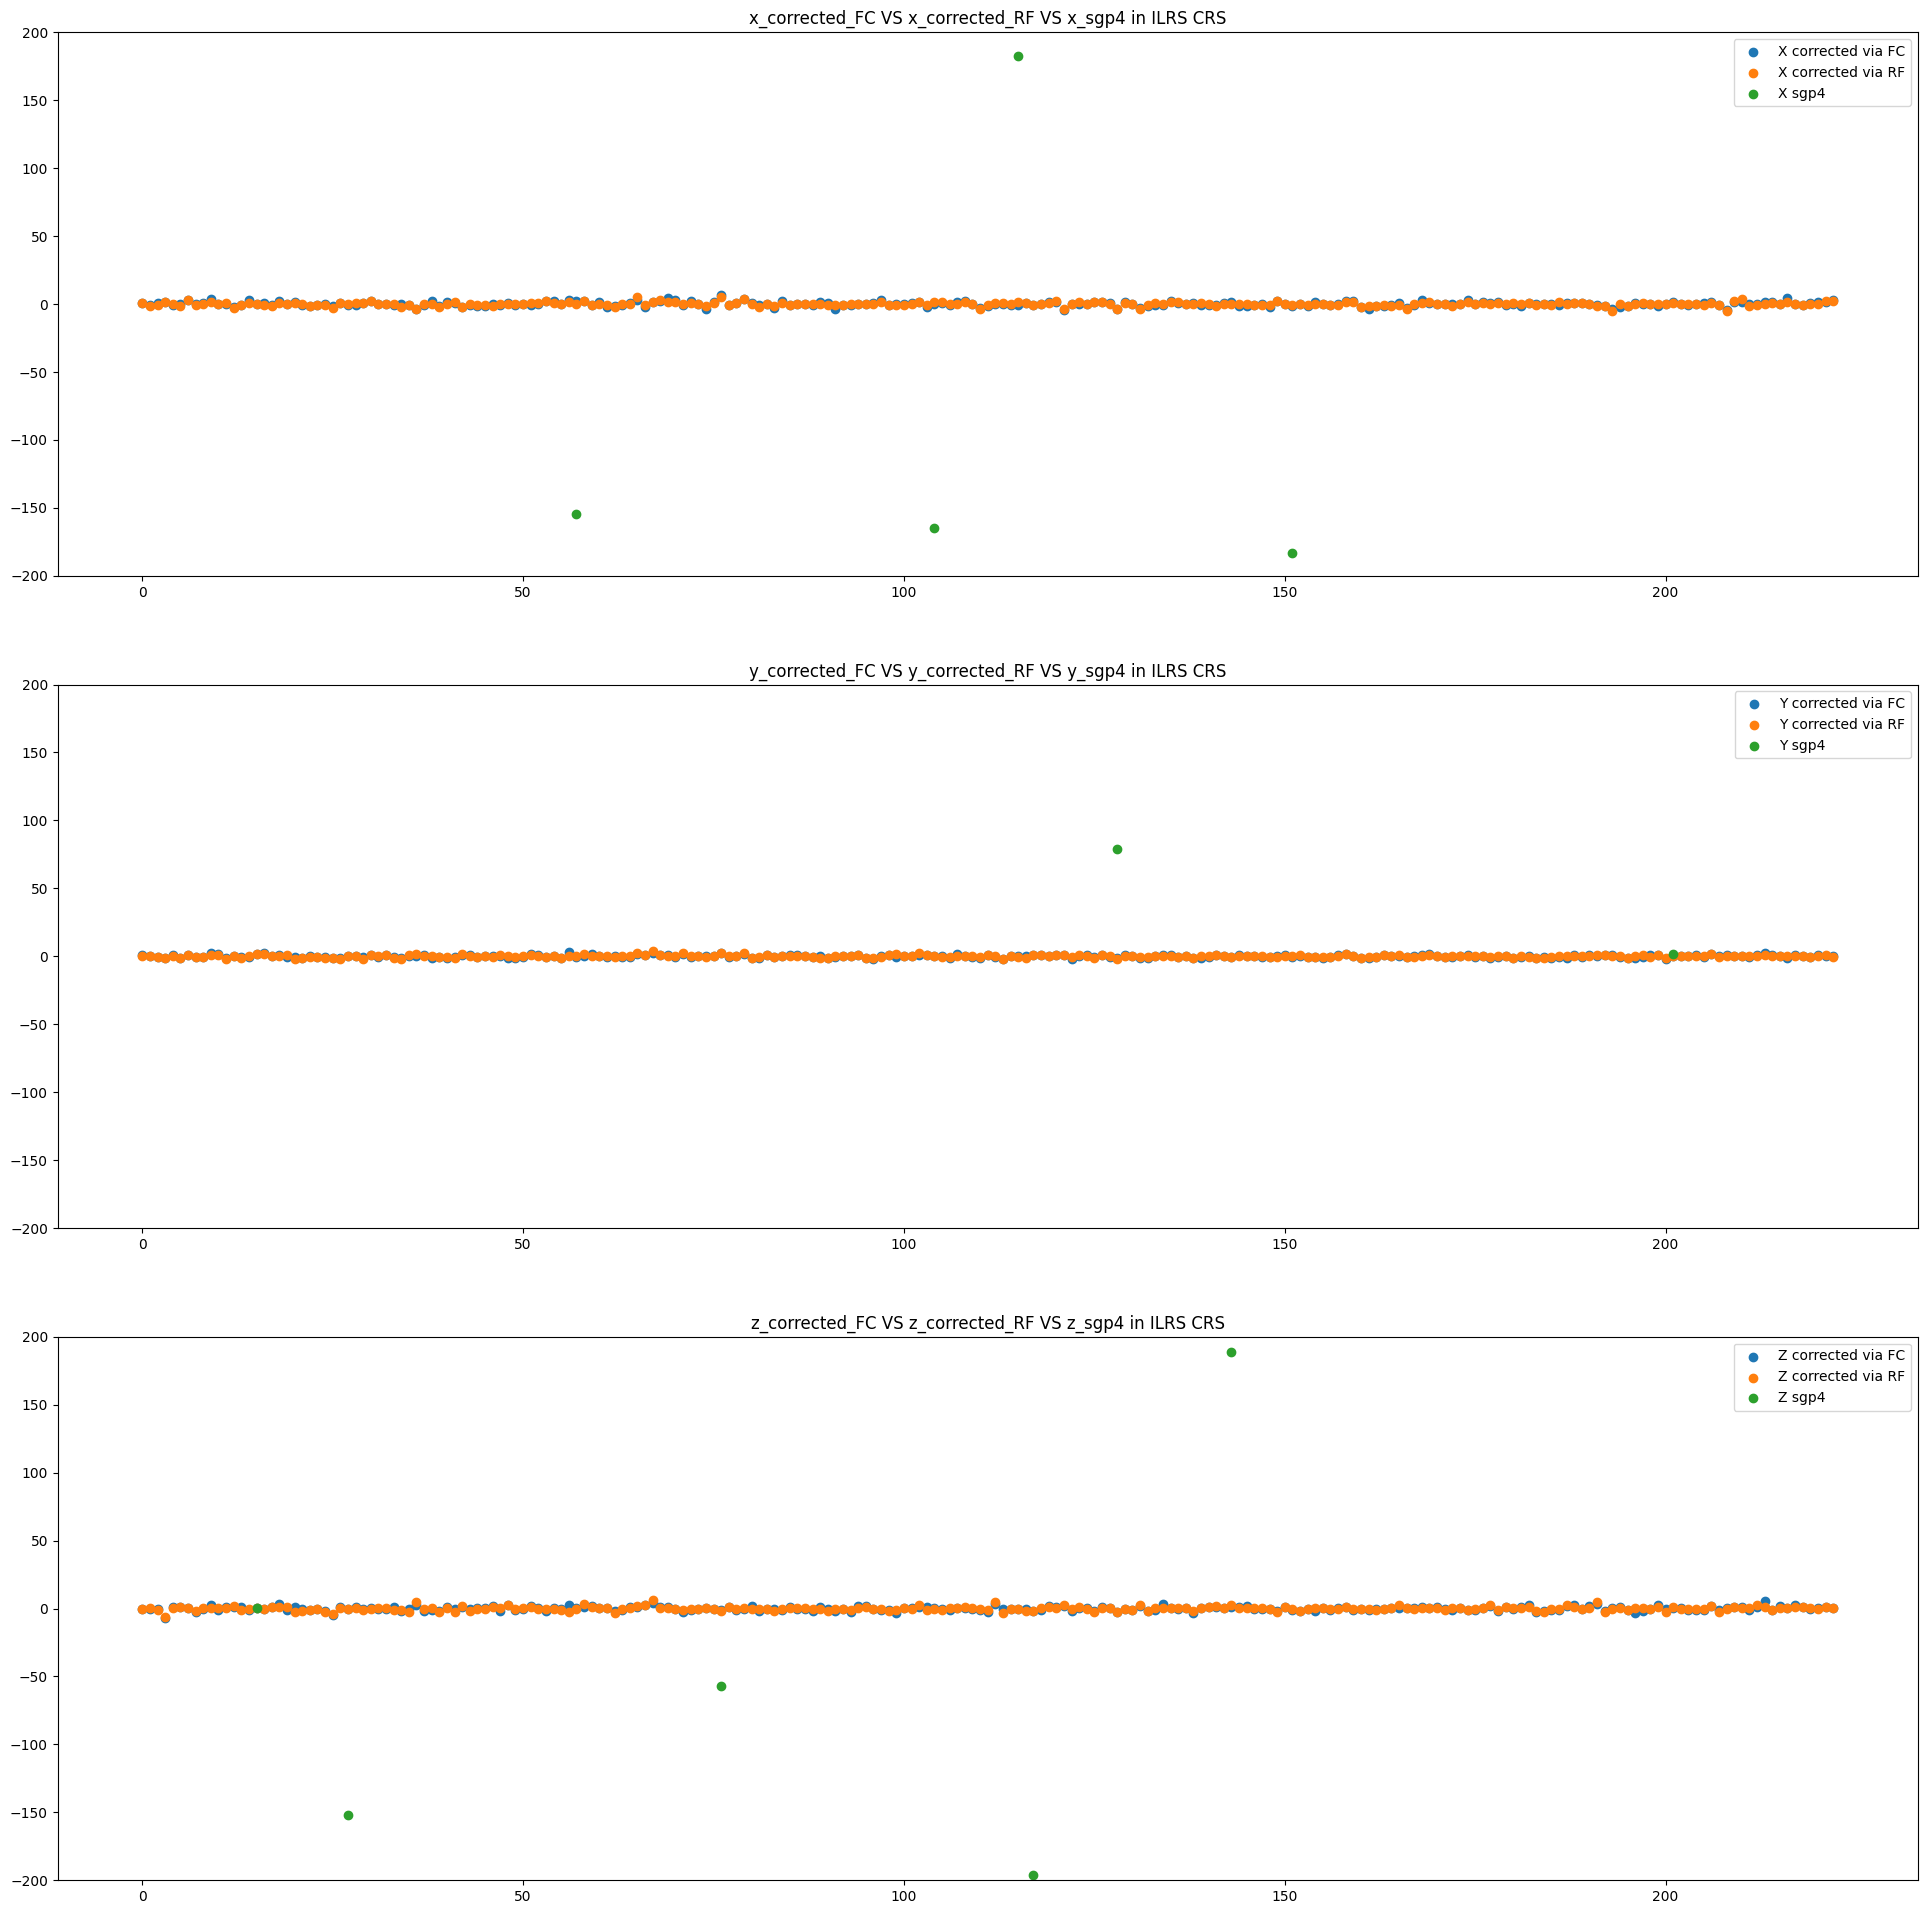

In [ ]:
corrected_xyz_ilrs_csr = corrected_xyz-ilrs_xyz_inv[:,:3]
corrected_xyz_rf_ilrs_csr = corrected_xyz_rf-ilrs_xyz_inv[:,:3]
corrected_x_ilrs_csr,corrected_y_ilrs_csr,corrected_z_ilrs_csr = corrected_xyz_ilrs_csr[:,0],corrected_xyz_ilrs_csr[:,1],corrected_xyz_ilrs_csr[:,2]
correctedrf_x_ilrs_csr,correctedrf_y_ilrs_csr,correctedrf_z_ilrs_csr = corrected_xyz_rf_ilrs_csr[:,0],corrected_xyz_rf_ilrs_csr[:,1],corrected_xyz_rf_ilrs_csr[:,2]
sgp4_x, sgp4_y, sgp4_z = sgp4_xyz[:,0], sgp4_xyz[:,1], sgp4_xyz[:,2]
ilrs_x_inv,ilrs_y_inv,ilrs_z_inv = ilrs_xyz_inv[:,0],ilrs_xyz_inv[:,1],ilrs_xyz_inv[:,2]
fig, ax = plt.subplots(3,1, figsize=(24,24))
#X
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_x_ilrs_csr, label='X corrected via FC')#false_clr)
ax[0].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_x_ilrs_csr, label='X corrected via RF')
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_x, label='X sgp4')
#Y
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_y_ilrs_csr, label='Y corrected via FC')#false_clr)
ax[1].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_y_ilrs_csr, label='Y corrected via RF')#false_clr)
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_y, label='Y sgp4')
#Z
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_z_ilrs_csr, label='Z corrected via FC')#false_clr)
ax[2].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_z_ilrs_csr, label='Z corrected via RF')
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),sgp4_z, label='Z sgp4')
#titles
ax[0].set_title('x_corrected_FC VS x_corrected_RF VS x_sgp4 in ILRS CRS')
ax[1].set_title('y_corrected_FC VS y_corrected_RF VS y_sgp4 in ILRS CRS')
ax[2].set_title('z_corrected_FC VS z_corrected_RF VS z_sgp4 in ILRS CRS')
bound = 200
ax[0].set_ylim(-bound, bound)
ax[1].set_ylim(-bound, bound)
ax[2].set_ylim(-bound, bound)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

**OK. LETS TRY CLASSIC ML AS WEL**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
modified_dataset[0]

array([tensor([ 2.0200e+03,  6.1609e+00, -2.2000e-07,  0.0000e+00,  1.0000e-04,
                6.5940e+01,  3.4449e+01,  1.1170e-03,  3.1785e+02,  2.8288e+01,
                2.1310e+00,  9.4920e+03,  2.1853e+04,  1.1848e+04, -5.6196e+03]),
       tensor([ 2.1851e+04,  1.1849e+04, -5.6157e+03,  1.1679e+00, -1.3442e+00,
               -3.9547e+00])                                                   ],
      dtype=object)

In [ ]:
X_test, Y_test, X_tr, Y_tr, d_test  = [],[],[],[],[]
for sample in trainset:
    x, y  = sample[0].numpy(),sample[1].numpy()
    X_tr.append(x)
    Y_tr.append(y)
for sample in testset:
    x, y  = sample[0].numpy(),sample[1].numpy()
    X_test.append(x)
    Y_test.append(y)
#d_test = unnormalize(np.array(d_test), mean_delta, std_delta)
Y_test = unnormalize(np.array(Y_test), mean_y, std_y)
Y_tr = unnormalize(np.array(Y_tr), mean_y, std_y)
tr_ilrs, tr_delta_r = Y_tr[:,:3], Y_tr[:,3:]
test_ilrs, test_delta_r = Y_test[:,:3], Y_test[:,3:]
test_sgp4_xyz = np.array(X_test)[:,-3:]
test_sgp4_xyz = unnormalize(test_sgp4_xyz, mean_sgp4, std_sgp4)
len(X_test),len(X_tr)

(223, 1679)

In [ ]:
#modified_dataset[0]
X_all, Y_all = [],[]
for sample in modified_dataset:
    X_all.append(sample[0].numpy())
    Y_all.append(sample[1].numpy())
X_all[0],Y_all[0]

(array([ 2.0200000e+03,  6.1608772e+00, -2.2000000e-07,  0.0000000e+00,
         9.9999997e-05,  6.5940102e+01,  3.4449402e+01,  1.1170000e-03,
         3.1784689e+02,  2.8287500e+01,  2.1310358e+00,  9.4920000e+03,
         2.1852662e+04,  1.1847676e+04, -5.6196245e+03], dtype=float32),
 array([ 2.18514941e+04,  1.18490205e+04, -5.61566992e+03,  1.16787338e+00,
        -1.34416497e+00, -3.95465231e+00], dtype=float32))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)
delta_train, delta_test, ilrs_train, ilrs_test = np.array(y_train)[:,3:], np.array(y_test)[:,3:],np.array(y_train)[:,:3], np.array(y_test)[:,:3]
print(delta_train.shape,delta_test.shape,ilrs_train.shape,ilrs_test.shape)

(1790, 3) (448, 3) (1790, 3) (448, 3)


In [ ]:
# DEFINE RF AND FIT IT
rf = RandomForestRegressor(n_estimators = 500, n_jobs=-1)
rf = rf.fit(X_tr, tr_delta_r)

In [ ]:
y_pred = rf.predict(X_test)
corrected_xyz_rf = test_sgp4_xyz-y_pred
rmse = np.sqrt(criterion(torch.tensor(corrected_xyz_rf), torch.tensor(test_ilrs)).item())
real_rmse = np.sqrt(criterion(torch.tensor(test_sgp4_xyz), torch.tensor(test_ilrs)))
print('rmse =',rmse, '\nreal rmse', real_rmse)

rmse = 1.2620093541450343 
real rmse tensor(2.0503)


**COMPARISON RF VS FC MODELS ON THE SAME TEST DATA OF GLONASS**

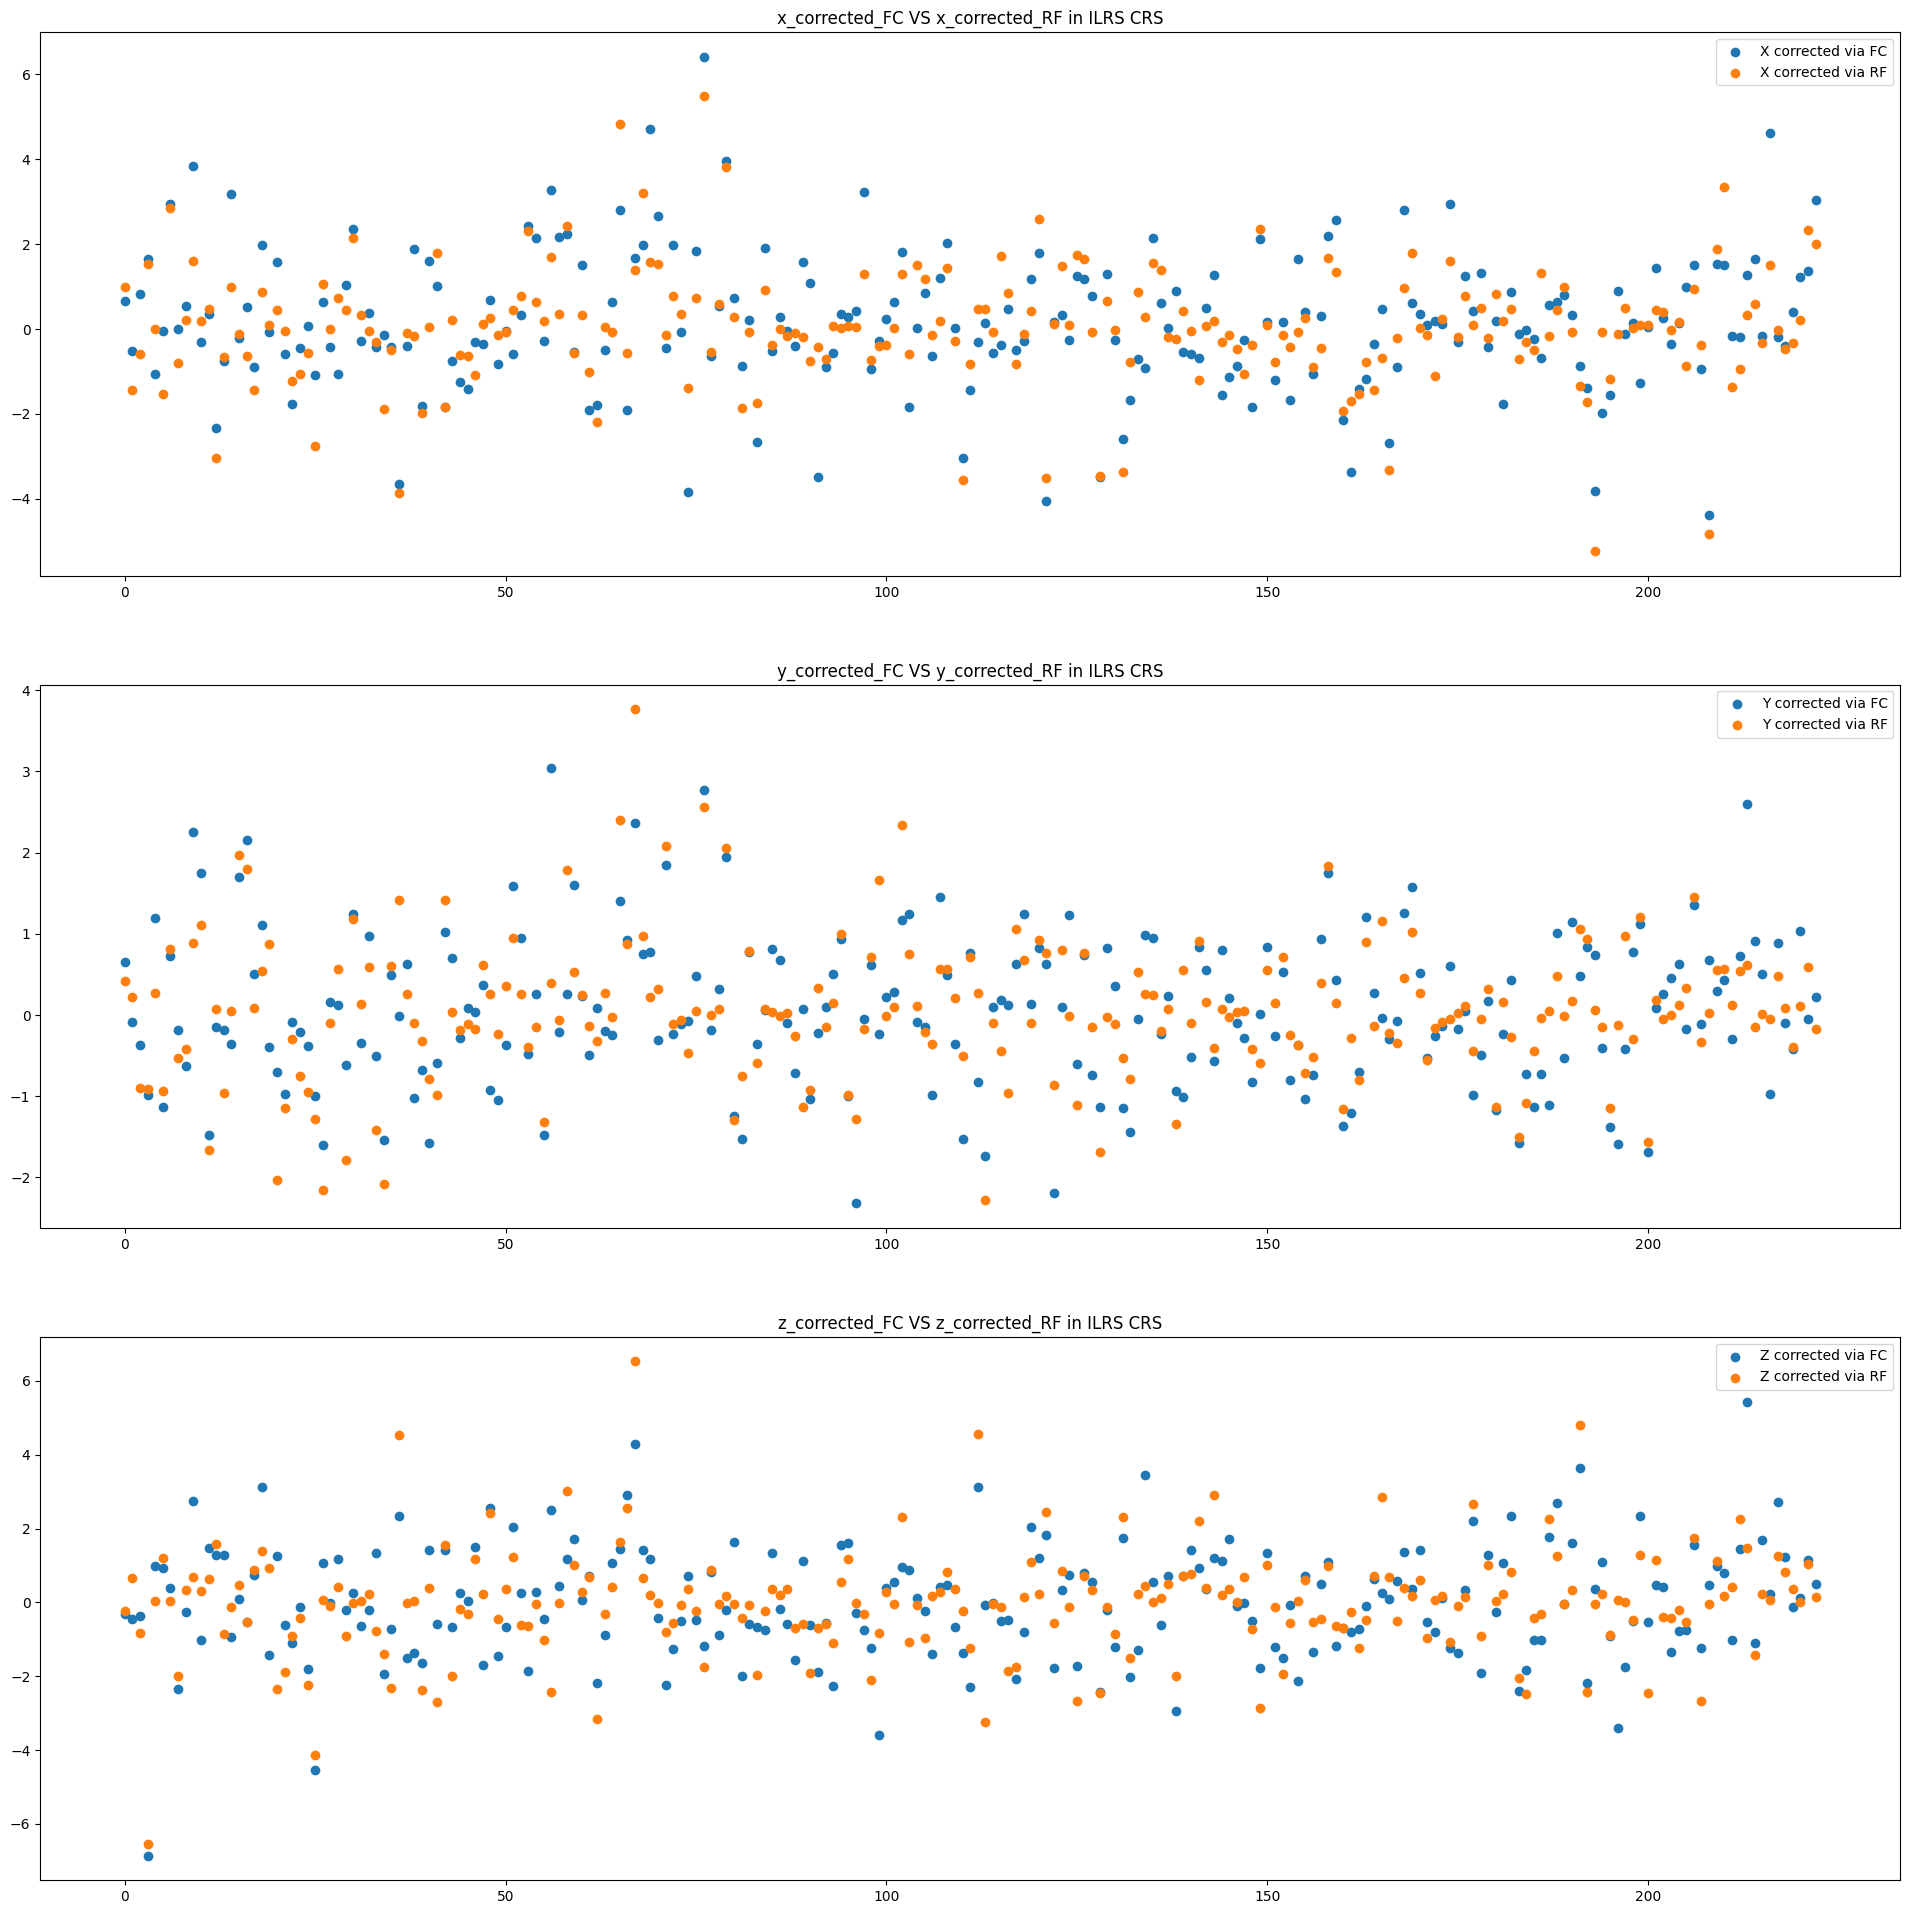

In [ ]:
corrected_xyz_ilrs_csr = corrected_xyz-ilrs_xyz_inv[:,:3]
corrected_xyz_rf_ilrs_csr = corrected_xyz_rf-ilrs_xyz_inv[:,:3]
corrected_x_ilrs_csr,corrected_y_ilrs_csr,corrected_z_ilrs_csr = corrected_xyz_ilrs_csr[:,0],corrected_xyz_ilrs_csr[:,1],corrected_xyz_ilrs_csr[:,2]
correctedrf_x_ilrs_csr,correctedrf_y_ilrs_csr,correctedrf_z_ilrs_csr = corrected_xyz_rf_ilrs_csr[:,0],corrected_xyz_rf_ilrs_csr[:,1],corrected_xyz_rf_ilrs_csr[:,2]
sgp4_x, sgp4_y, sgp4_z = sgp4_xyz[:,0], sgp4_xyz[:,1], sgp4_xyz[:,2]
ilrs_x_inv,ilrs_y_inv,ilrs_z_inv = ilrs_xyz_inv[:,0],ilrs_xyz_inv[:,1],ilrs_xyz_inv[:,2]
fig, ax = plt.subplots(3,1, figsize=(24,24))
#X
ax[0].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_x_ilrs_csr, label='X corrected via FC')#false_clr)
ax[0].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_x_ilrs_csr, label='X corrected via RF')
#Y
ax[1].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_y_ilrs_csr, label='Y corrected via FC')#false_clr)
ax[1].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_y_ilrs_csr, label='Y corrected via RF')#false_clr)
#Z
ax[2].scatter(np.arange(len(corrected_x_ilrs_csr)),corrected_z_ilrs_csr, label='Z corrected via FC')#false_clr)
ax[2].scatter(np.arange(len(correctedrf_x_ilrs_csr)),correctedrf_z_ilrs_csr, label='Z corrected via RF')
#titles
ax[0].set_title('x_corrected_FC VS x_corrected_RF in ILRS CRS')
ax[1].set_title('y_corrected_FC VS y_corrected_RF in ILRS CRS')
ax[2].set_title('z_corrected_FC VS z_corrected_RF in ILRS CRS')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

**AS WE CAN SEE RANDOM FOREST FAILED AS WELL, EVEN WORSE, THAN FC**

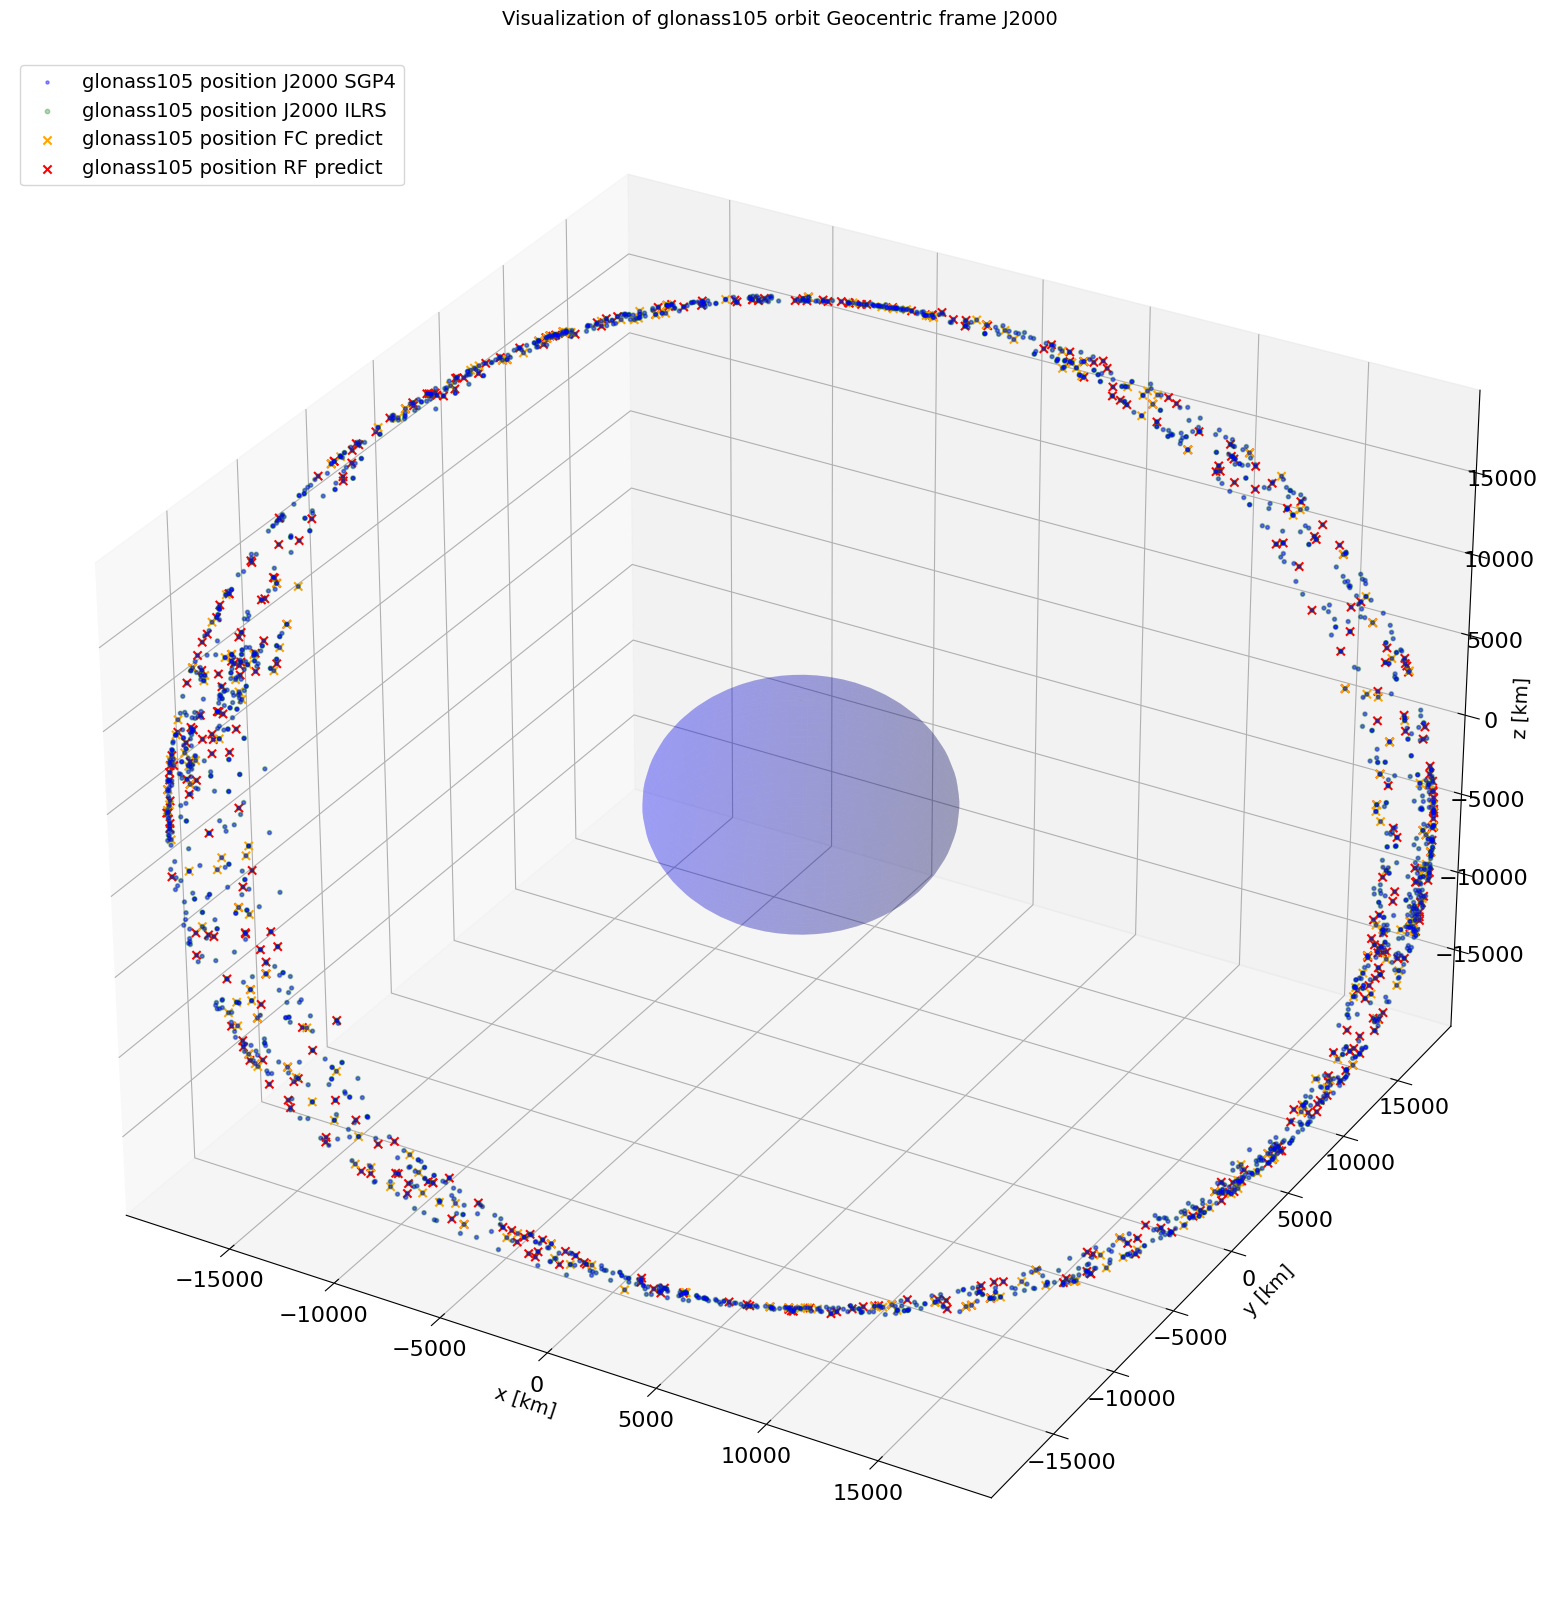

In [ ]:
#%matplotlib qt
#corrected_xyz = sgp4_xyz-outputs_inv
#corrected_xyz_rf = test_sgp4_xyz-y_pred
fig=plt.figure(figsize=(20,20))#Create 3D axes
ax = plt.axes(projection='3d')
plt.rcParams['font.size'] = '16'
r_Earth= 6400
# making grid for Earth to visualize
NN = 50
phi = np.linspace(0, 2 * np.pi, NN)
theta = np.linspace(0, np.pi, NN)
theta, phi = np.meshgrid(theta, phi)
X_e = r_Earth * np.cos(phi) * np.sin(theta)
Y_e = r_Earth * np.sin(phi) * np.sin(theta)
Z_e = r_Earth * np.cos(theta)
# plotting Earth as a sphere wit radius of r_Earth
e_surf = ax.plot_surface(X_e, Y_e, Z_e, color='blue', alpha=0.2)
e_surf._facecolors2d = e_surf._facecolor3d
e_surf._edgecolors2d = e_surf._edgecolor3d
# plotting dynamics of earth LEO sat around Earth
ax.scatter(sgp4_coords['x_j2000_tle'],sgp4_coords['y_j2000_tle'],sgp4_coords['z_j2000_tle'],color="blue",marker="o",s=5,alpha=0.4,label="satellite position J2000 SGP4")
ax.scatter(ilrs_coords['x_j2000_ilrs_Akima'],ilrs_coords['y_j2000_ilrs_Akima'],ilrs_coords['z_j2000_ilrs_Akima'],color="green",s=10,alpha=0.3,label="satellite position J2000 ILRS")
ax.scatter(corrected_xyz[:,0],corrected_xyz[:,1],corrected_xyz[:,2],color="orange",marker="x",s=35,alpha=1,label="satellite position FC predict"  )
ax.scatter(corrected_xyz_rf[:,0],corrected_xyz_rf[:,1],corrected_xyz_rf[:,2],color="red",marker="x",s=35,alpha=1,label="satellite position RF predict"  )
# axis labeling
ax.set_xlabel("x [km]",fontsize=14)
ax.set_ylabel("y [km]",fontsize=14)
ax.set_zlabel("z [km]",fontsize=14)
ax.set_title("Visualization of satellite orbit in Geocentric frame J2000\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)

ax.set_xlim3d(-3.*r_Earth, 3.*r_Earth)
ax.set_ylim3d(-3.*r_Earth, 3.*r_Earth)
ax.set_zlim3d(-3.*r_Earth, 3.*r_Earth)
plt.show()

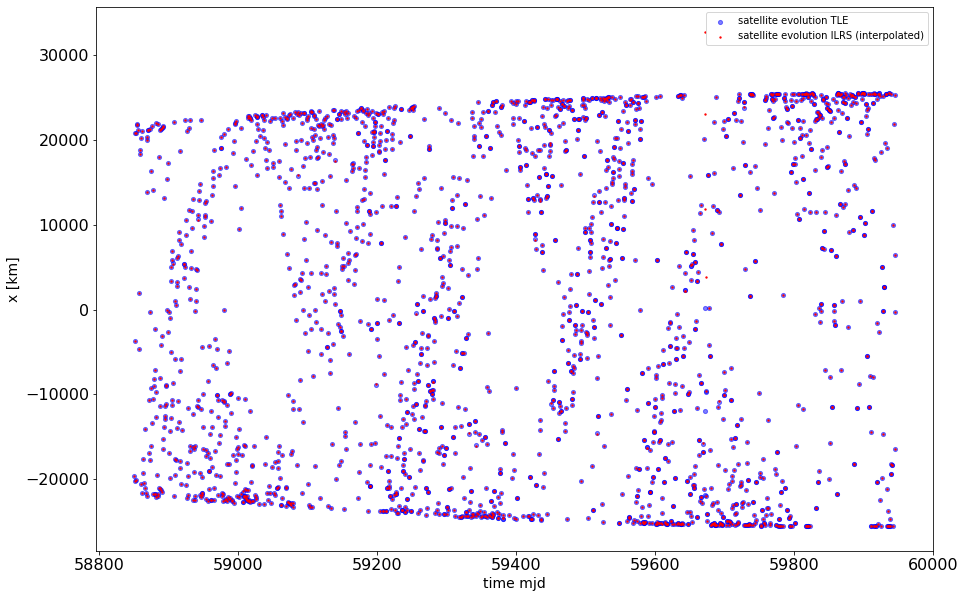

In [ ]:
# x(t) axis
fig=plt.figure(figsize=(15,10))
plt.scatter(df_tle_ilrs['mjd_t'],sgp4_coords['x_j2000_tle'], s=17, color ='blue',alpha= 0.5, label ='satellite evolution TLE')
plt.scatter(df_tle_ilrs['mjd_t'],ilrs_coords['x_j2000_ilrs_Akima'], s=2,color ='red',alpha= 0.9, label ='satellite evolution ILRS (interpolated)')
plt.ylabel("x [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()

In [ ]:
# y(t) axis
fig=plt.figure(figsize=(15,10))
plt.plot(ILRS_df['mjd'],ILRS_df['y_j2000'], color ='blue',alpha= 0.5, label ='satellite evo ILRS')
plt.scatter(j2000_coords_from_TLE['mjd_t'],j2000_coords_from_TLE['y_j2000_tle'], s=10,color ='red',alpha= 0.7, label ='satellite evo from TLE')
plt.ylabel("y [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()

In [ ]:
# z(t) axis
fig=plt.figure(figsize=(15,10))
plt.plot(ILRS_df['mjd'],ILRS_df['z_j2000'], color ='blue',alpha= 0.5, label ='satellite evo ILRS')
plt.scatter(j2000_coords_from_TLE['mjd_t'],j2000_coords_from_TLE['z_j2000_tle'], s=10,color ='red',alpha= 0.7, label ='satellite evo from TLE')
plt.ylabel("z [km]",fontsize=14)
plt.xlabel("time mjd",fontsize=14)
plt.legend(loc="upper right",fontsize=10)
plt.show()